https://lmfit.github.io/lmfit-py/index.html

In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import pickle
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from edfreader import read_edf
import numpy as np
%matplotlib notebook

from lmfit.models import StepModel
from lmfit import  Model, Parameters

In [2]:
timeStr = '2017-07-21_142241'
observer = 'laurent'
mode = 'enregistrement'

In [3]:
file = os.path.join('..', 'data', mode + '_' + observer + '_' + timeStr + '.pkl')
with open(file, 'rb') as fichier :
    exp = pickle.load(fichier, encoding='latin1')
      
resultats = os.path.join('..', 'data', mode + '_' + observer + '_' + timeStr + '.asc')
data = read_edf(resultats, 'TRIALID')

In [4]:
N_trials = exp['N_trials']
N_blocks = exp['N_blocks']
screen_width_px = exp['screen_width_px']
screen_height_px = exp['screen_height_px']
V_X = exp['V_X']
RashBass = exp['RashBass']
stim_tau = exp['stim_tau']
p = exp['p']

# Test Fit -- StepModel

In [5]:
trial = 0
block = 0
trial_data = trial + N_trials*block

data_x = data[trial_data]['x']

trackertime = data[trial_data]['trackertime']
StimulusOn = data[trial_data]['events']['msg'][10][0]
StimulusOf = data[trial_data]['events']['msg'][14][0]
TargetOn = data[trial_data]['events']['msg'][15][0]
TargetOff = data[trial_data]['events']['msg'][16][0]
saccades = data[trial_data]['events']['Esac']

start = TargetOn

StimulusOn = StimulusOn - start
StimulusOf = StimulusOf - start
TargetOn = TargetOn - start
TargetOff = TargetOff - start
trackertime = trackertime - start
trackertime_0 = data[trial_data]['trackertime'][0]

In [6]:
gradient_x = np.gradient(data_x)
mod =  StepModel(form='erf')
pars = mod.guess(gradient_x, x=trackertime) 
out = mod.fit(gradient_x, pars, x=trackertime)

print(out.fit_report())

[[Model]]
    Model(step, form='erf')
[[Fit Statistics]]
    # function evals   = 84
    # data points      = 2175
    # variables        = 3
    chi-square         = 533.241
    reduced chi-square = 0.246
    Akaike info crit   = -3051.636
    Bayesian info crit = -3034.582
[[Variables]]
    sigma:       34.7536497 +/- 28.48124 (81.95%) (init= 310.5714)
    center:      229.281914 +/- 14.30644 (6.24%) (init= 36)
    amplitude:   0.32811550 +/- 0.017050 (5.20%) (init= 9.75)
[[Correlations]] (unreported correlations are <  0.100)
    C(center, amplitude)         =  0.159 
    C(sigma, amplitude)          =  0.127 



<IPython.core.display.Javascript object>


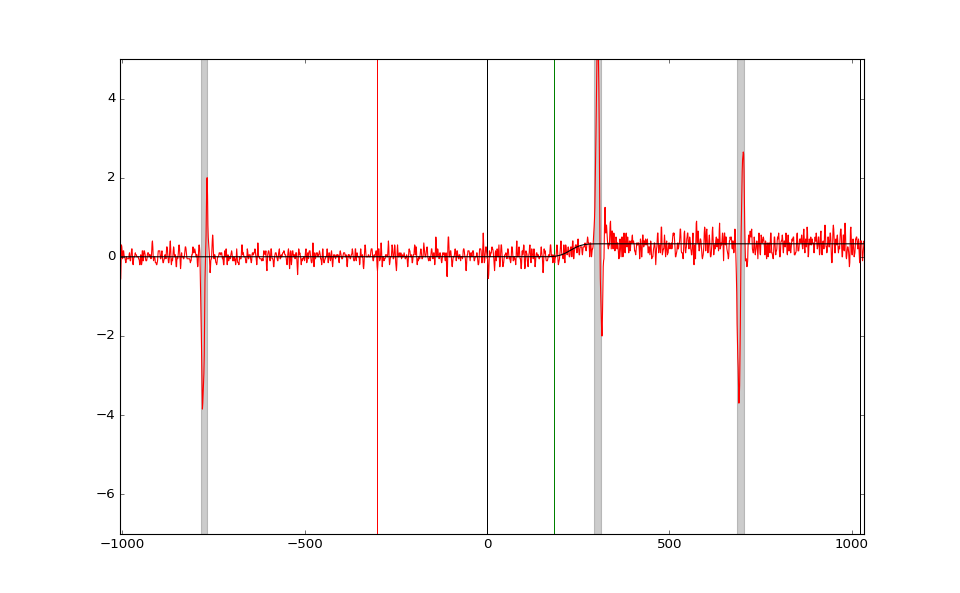

latence =  184


<Container object of 1 artists>

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, (12/1.6180)))

ax.axis([StimulusOn-10, TargetOff+10, -7, 5])
ax.plot(trackertime, gradient_x, color='r')
#ax.plot(trackertime, out.init_fit, 'k--')
ax.plot(trackertime, out.best_fit, color='k')


for s in range(len(saccades)) :
    ax. axvspan(saccades[s][0]-start, saccades[s][1]-start, color='k', alpha=0.2)

liste_l =[]
dir_bool = p[trial, block, 0]*2 - 1
for tps in range(len(trackertime)) :
    if dir_bool*out.best_fit[tps] >= 0.01 :
        liste_l.append(trackertime[tps])
if len(liste_l)!=0:
    latence = liste_l[0]
    ax.bar(latence, 12, bottom=-7, color='g', width=2, linewidth=0)
    print('latence = ', latence)
else:
    ax.text(StimulusOf+100, 3.5, "PAS DE LATENCE !", color='r', fontsize=15)

# ax.text(StimulusOn+15, -7, "%s"%(out.fit_report()), color='k', fontsize=6)

ax.bar(StimulusOn, 12, bottom=-7, color='r', width=2, linewidth=0)
ax.bar(StimulusOf, 12, bottom=-7, color='r', width=2, linewidth=0)

ax.bar(TargetOn, 12, bottom=-7, color='k', width=2, linewidth=0)
ax.bar(TargetOff, 12, bottom=-7, color='k', width=2, linewidth=0)

**Ne marche pas super bien pour tous les essais**

# Test Fit -- Fonction Vitesse

In [8]:
def test_vitesse (x, tau=0.013, xT=0.01, t_T=0.9, start=1200.) :
    '''
    tau -- constante de l'oeuil (0.013)
    xT -- position en deg de la cible (1)
    t_T -- tps du mvt - s (0.1)
    start -- tps où commence le mvt
    '''
    
    dt = 0.001
    T = int(t_T/dt) # tps termine mvt - ms
    time = np.arange(len(x))/1000 # en seconde !!!

    rho = tau/t_T*np.log((1+np.exp(t_T/tau))/2) # proportion accélération dans mvt
    rhoT = int(np.round(T*rho)) # tps accélération
    Umax = 1/tau*xT/((2*rho-1)*t_T-tau*(2-np.exp(-rho*t_T/tau)-np.exp((1-rho)*t_T/tau))) # signal N
    x_max = Umax*tau*(1-np.exp(-1/tau*time[rhoT]))

    return  np.concatenate(((0*np.ones(len(time[0:int(start)])), Umax*tau*(1-np.exp(-1/tau*time[0:rhoT])), x_max*np.ones(len(time[rhoT+int(start):])))))

2175


<IPython.core.display.Javascript object>


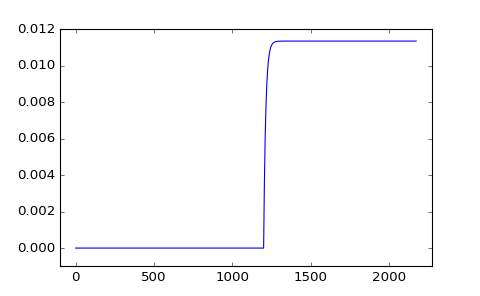

In [9]:
print(len(test_vitesse(trackertime)))

fig, ax = plt.subplots(1, 1, figsize=(6, (6/1.6180)))
ax.axis([0-100, len(trackertime)+100, -0.001, 0.012])
plt.plot(test_vitesse(trackertime))

## PROBLEME

**problème avec start** : ne se modifie pas (ou très peut) -- obliger de le rentrer à la main !

**Pose problème pour trouver la latence !**

[[Model]]
    Model(test_vitesse)
[[Fit Statistics]]
    # function evals   = 57
    # data points      = 2175
    # variables        = 4
    chi-square         = 585.775
    reduced chi-square = 0.270
    Akaike info crit   = -2845.269
    Bayesian info crit = -2822.530
[[Variables]]
    tau:     0.09985317 +/- 0        (0.00%) (init= 0.013)
    xT:      0.01638844 +/- 0        (0.00%) (init= 0.05)
    t_T:     0.19834671 +/- 0        (0.00%) (init= 0.1)
    start:   99.9999522 +/- 0        (0.00%) (init= 100)



<IPython.core.display.Javascript object>


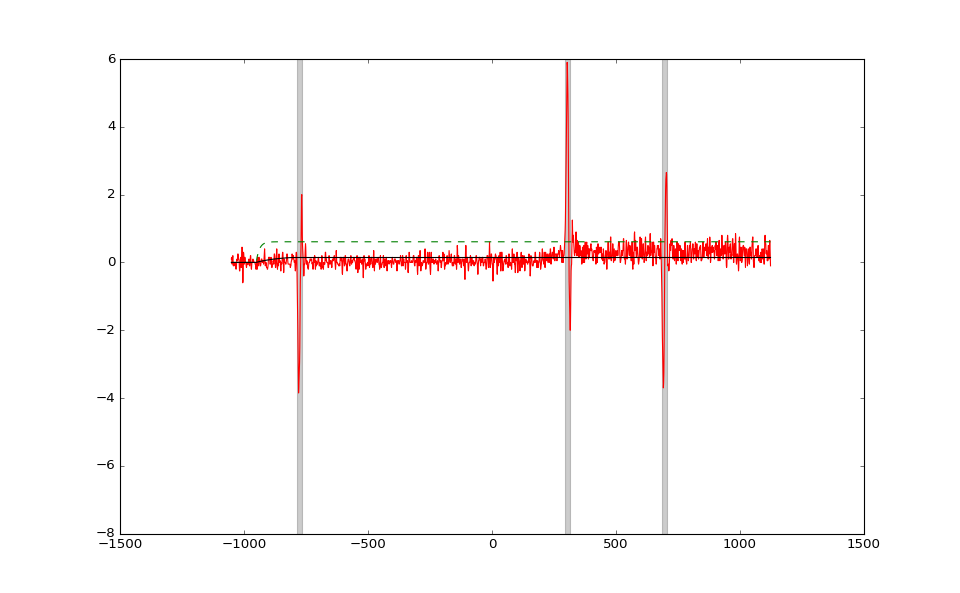

<Container object of 1 artists>

In [10]:
gradient_x = np.gradient(data_x)

model = Model(test_vitesse)

params = Parameters()
params.add('tau', value=0.013, min=0.001, max=0.1)#, vary=False)
params.add('xT', value=0.05, min=0.001, max=0.1)#, vary=False)
params.add('t_T', value= 0.1, min=0.001, max=0.2)#, vary=False)
params.add('start', value=100., min=0, max=2000.)#, vary=True)

result = model.fit(gradient_x, params, x=trackertime)
print(result.fit_report())

fig, ax = plt.subplots(1, 1, figsize=(12, (12/1.6180)))

#ax.axis([StimulusOn-10, TargetOff+10, -7, 5])
ax.plot(trackertime, gradient_x, color='r')

ax.plot(trackertime, result.init_fit, 'g--')
ax.plot(trackertime, result.best_fit, 'k')

for s in range(len(saccades)) :
    ax. axvspan(saccades[s][0]-start, saccades[s][1]-start, color='k', alpha=0.2)

ax.bar(StimulusOn, 12, bottom=-7, color='r', width=2, linewidth=0)
ax.bar(StimulusOf, 12, bottom=-7, color='r', width=2, linewidth=0)

ax.bar(TargetOn, 12, bottom=-7, color='k', width=2, linewidth=0)
ax.bar(TargetOff, 12, bottom=-7, color='k', width=2, linewidth=0)


# Résolution du problème

- changement de la fonction vitesse

le fit change enfin corectement le start

In [11]:
def vitesse (x, tau=0.013, xT=0.1, t_T=1, start=1200., bino=1) :

    '''
    tau -- constante temps oeuil (0.013)
    t_T -- tps du mvt - s (0.1)
    xT -- position en deg de la cible (1)
    start -- tps où commence le mvt
    bino -- binomial
    '''    
    
    if bino == 0:
        xT =xT*-1
        
    #dt = 0.001
    #T = int(t_T/dt) # tps termine mvt - ms
    
    time = np.arange(len(x))/1000 # en seconde !!!
    start = start/1000 # en seconde !!!
    rho = tau/t_T*np.log((1+np.exp(t_T/tau))/2) # proportion accélération dans mvt
    
    #rhoT = int(np.round(T*rho)) # tps accélération
    
    Umax = 1/tau*xT/((2*rho-1)*t_T-tau*(2-np.exp(-rho*t_T/tau)-np.exp((1-rho)*t_T/tau))) # signal N

    vitesse = []
    for t in range(len(time)):
        if bino==0 :
            if Umax*tau*(1-np.exp(-1/tau*(time[t]-start))) > 0 :
                vitesse.append(0)
            else :
                vitesse.append(Umax*tau*(1-np.exp(-1/tau*(time[t]-start))))
        else :
            if Umax*tau*(1-np.exp(-1/tau*(time[t]-start))) < 0 :
                vitesse.append(0)
            else :
                vitesse.append(Umax*tau*(1-np.exp(-1/tau*(time[t]-start))))
    return vitesse

2175


<IPython.core.display.Javascript object>


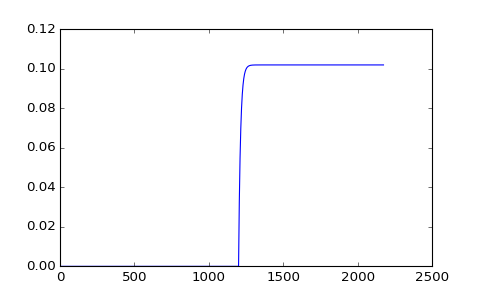

In [12]:
print(len(vitesse(trackertime)))

fig, ax = plt.subplots(1, 1, figsize=(6, (6/1.6180)))
plt.plot(vitesse(trackertime))

In [13]:
trial = 0
block = 0
trial_data = trial + N_trials*block

bino = p[trial, block, 0]

data_x = data[trial_data]['x']

trackertime = data[trial_data]['trackertime']
StimulusOn = data[trial_data]['events']['msg'][10][0]
StimulusOf = data[trial_data]['events']['msg'][14][0]
TargetOn = data[trial_data]['events']['msg'][15][0]
TargetOff = data[trial_data]['events']['msg'][16][0]
saccades = data[trial_data]['events']['Esac']

start = TargetOn

StimulusOn = StimulusOn - start
StimulusOf = StimulusOf - start
TargetOn = TargetOn - start
TargetOff = TargetOff - start
trackertime = trackertime - start

[[Model]]
    Model(vitesse)
[[Fit Statistics]]
    # function evals   = 144
    # data points      = 2175
    # variables        = 4
    chi-square         = 533.580
    reduced chi-square = 0.246
    Akaike info crit   = -3048.255
    Bayesian info crit = -3025.516
[[Variables]]
    tau:     0.01510954 +/- 0.016488 (109.13%) (init= 0.013)
    xT:      0.05621764 +/- 2.36e+04 (42055384.64%) (init= 0.05)
    t_T:     0.19319418 +/- 7.24e+04 (37495517.65%) (init= 0.1)
    start:   1264.99296 +/- 11.12864 (0.88%) (init= 1000)
    bino:    1 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(xT, t_T)                   =  1.000 
    C(tau, start)                = -0.683 



<IPython.core.display.Javascript object>


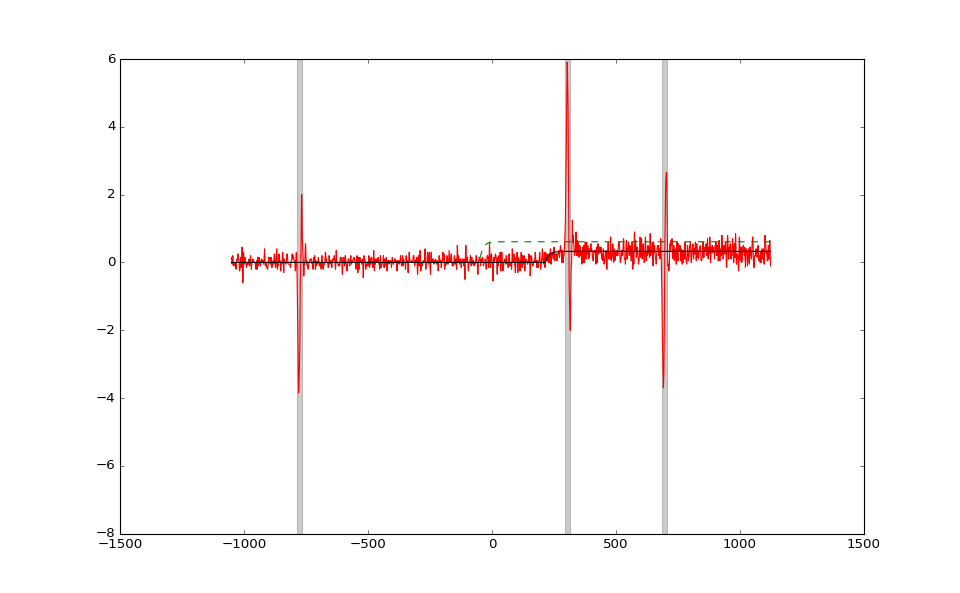

<Container object of 1 artists>

In [14]:
gradient_x = np.gradient(data_x)

model = Model(vitesse)

params = Parameters()
params.add('tau', value=0.013, min=0.001, max=0.1)#, vary=False)
params.add('xT', value=0.05, min=0.001, max=0.1)#, vary=False)
params.add('t_T', value= 0.1, min=0.001, max=0.2)#, vary=False)
params.add('start', value=1000., min=0, max=2000.)#, vary=True)
params.add('bino', value=bino, min=0, max=1, vary=False)


result = model.fit(gradient_x, params, x=trackertime)
print(result.fit_report())

fig, ax = plt.subplots(1, 1, figsize=(12, (12/1.6180)))

#ax.axis([StimulusOn-10, TargetOff+10, -7, 5])
ax.plot(trackertime, gradient_x, color='r')

ax.plot(trackertime, result.init_fit, 'g--')
ax.plot(trackertime, result.best_fit, 'k')

for s in range(len(saccades)) :
    ax. axvspan(saccades[s][0]-start, saccades[s][1]-start, color='k', alpha=0.2)

ax.bar(StimulusOn, 12, bottom=-7, color='r', width=2, linewidth=0)
ax.bar(StimulusOf, 12, bottom=-7, color='r', width=2, linewidth=0)

ax.bar(TargetOn, 12, bottom=-7, color='k', width=2, linewidth=0)
ax.bar(TargetOff, 12, bottom=-7, color='k', width=2, linewidth=0)


on doit maintenant supprimer les saccades afin de voir si cela marche vraiment correctement

# Test suppression Saccades

In [15]:

print(saccades)

[[412938, 412955, 18, 654.5, 498.8, 625.7, 502.5], [414017, 414036, 20, 668.1, 506.6, 721.8, 504.4], [414409, 414427, 19, 826.6, 504.1, 814.0, 503.8]]


In [16]:
new_data=[]
new_gradient_x=[]
new_time=[]

t=0
for x in range(len(data_x)):
    saccade = None
    for s in range(len(saccades)) :
        if x in np.arange((saccades[s][0]-trackertime_0), (saccades[s][1]-trackertime_0+1+4)) :
            saccade = 'yes'
    if not saccade :
        new_data.append(data_x[x])
        new_gradient_x.append(gradient_x[x])
        new_time.append(t)
        t = t+1
    saccade = None

In [17]:
debut  = data[trial_data]['events']['msg'][15][0]-trackertime_0

<IPython.core.display.Javascript object>


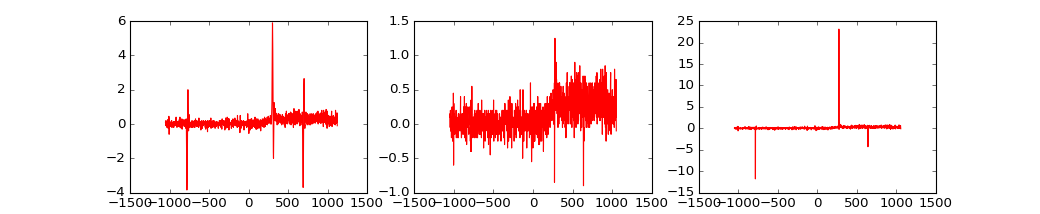

In [18]:
new_gradient_x2 = np.gradient(new_data)

fig, ax = plt.subplots(1, 3, figsize=(13, (13/(1.6180*3))))

ax[0].plot(trackertime, gradient_x, color='r')
ax[1].plot(np.asarray(new_time)-debut, new_gradient_x, color='r')
ax[2].plot(np.asarray(new_time)-debut, new_gradient_x2, color='r')

# Test Fit stepModel et fonction vitesse sur nouvelles données

In [19]:
debut  = data[trial_data]['events']['msg'][15][0]-trackertime_0
bino = p[trial, block, 0]

[[Model]]
    Model(step, form='erf')
[[Fit Statistics]]
    # function evals   = 63
    # data points      = 2106
    # variables        = 3
    chi-square         = 66.111
    reduced chi-square = 0.031
    Akaike info crit   = -7283.305
    Bayesian info crit = -7266.347
[[Variables]]
    sigma:       48.1794824 +/- 13.07675 (27.14%) (init= 300.7143)
    center:      1256.90399 +/- 6.582919 (0.52%) (init= 1052.5)
    amplitude:   0.30110338 +/- 0.006347 (2.11%) (init= 2.15)
[[Correlations]] (unreported correlations are <  0.100)
    C(center, amplitude)         =  0.193 
    C(sigma, amplitude)          =  0.155 



<IPython.core.display.Javascript object>


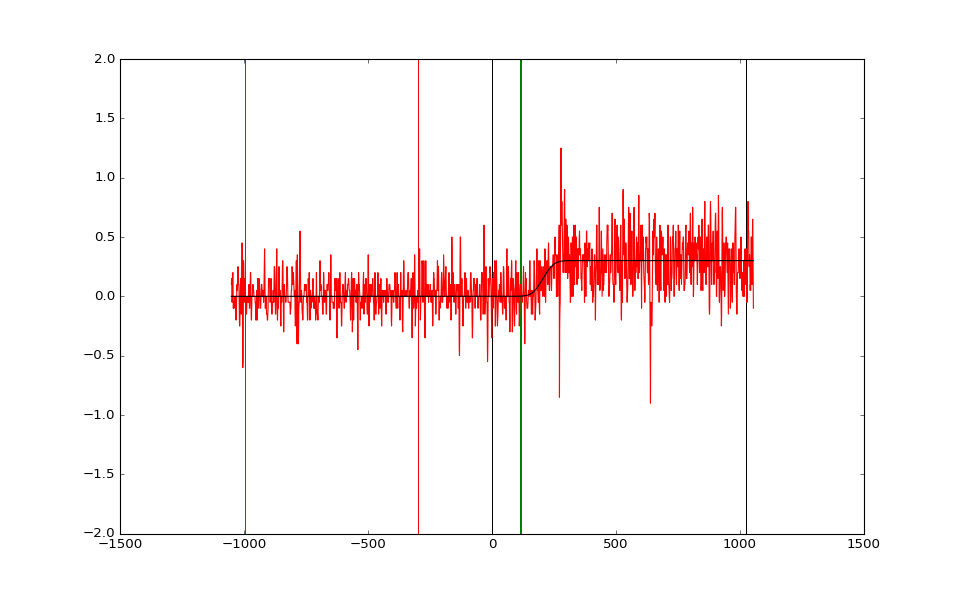

latence =  114


<Container object of 1 artists>

In [20]:
mod =  StepModel(form='erf')
pars = mod.guess(new_gradient_x, x=new_time) 
out = mod.fit(new_gradient_x, pars, x=new_time)

print(out.fit_report())

fig, ax = plt.subplots(1, 1, figsize=(12, (12/1.6180)))

ax.plot(np.asarray(new_time)-debut, new_gradient_x, color='r')
#ax.plot(np.asarray(new_time)-debut, out.init_fit, 'k--')
ax.plot(np.asarray(new_time)-debut, out.best_fit, color='k')

liste_l =[]
dir_bool = bino*2 - 1
for tps in range(len(new_time)) :
    if dir_bool*out.best_fit[tps] > 0.001 :
        liste_l.append(new_time[tps])
if len(liste_l)!=0:
    latence = liste_l[0]
    ax.bar(latence-debut, 4, bottom=-2, color='g', width=5, linewidth=0)
    print('latence = ', latence-debut)
else:
    ax.text(StimulusOf+10, 1.5, "PAS DE LATENCE !", color='r', fontsize=15)

# ax.text(StimulusOn+15, -7, "%s"%(out.fit_report()), color='k', fontsize=6)


ax.bar(StimulusOn, 4, bottom=-2, color='r', width=4, linewidth=0)
ax.bar(StimulusOf, 4, bottom=-2, color='r', width=4, linewidth=0)

ax.bar(TargetOn, 4, bottom=-2, color='k', width=4, linewidth=0)
ax.bar(TargetOff, 4, bottom=-2, color='k', width=4, linewidth=0)

[[Model]]
    Model(vitesse)
[[Fit Statistics]]
    # function evals   = 127
    # data points      = 2106
    # variables        = 4
    chi-square         = 66.247
    reduced chi-square = 0.032
    Akaike info crit   = -7276.968
    Bayesian info crit = -7254.358
[[Variables]]
    tau:     0.03855967 +/- 0.010887 (28.23%) (init= 0.013)
    xT:      0.04377149 +/- 3.00e+04 (68498071.27%) (init= 0.05)
    t_T:     0.19847910 +/- 9.95e+04 (50133457.05%) (init= 0.1)
    start:   1218.63599 +/- 7.357011 (0.60%) (init= 1000)
    bino:    1 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(xT, t_T)                   =  1.000 
    C(tau, start)                = -0.702 

latence =  167.635993122
new_latence = 185.635993122


<IPython.core.display.Javascript object>


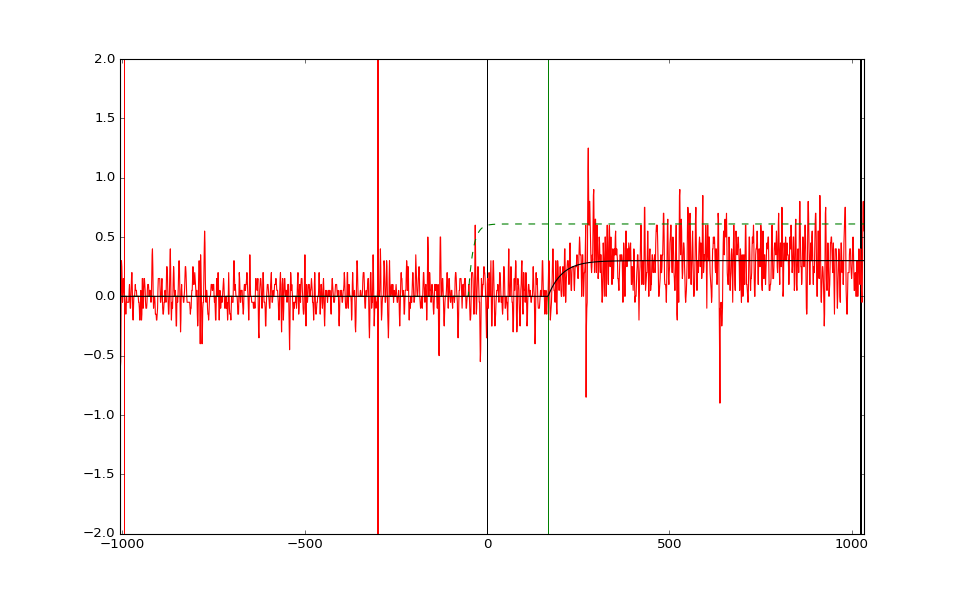

<Container object of 1 artists>

In [21]:
model = Model(vitesse)

params = Parameters()
params.add('tau', value=0.013, min=0.001, max=0.1)#, vary=False)
params.add('xT', value=0.05, min=0.001, max=0.1)#, vary=False)
params.add('t_T', value= 0.1, min=0.001, max=0.2)#, vary=False)
params.add('start', value=1000., min=0, max=2000.)#, vary=True)
params.add('bino', value=bino, min=0, max=1, vary=False)

result = model.fit(new_gradient_x, params, x=new_time)
print(result.fit_report())

latence = result.values['start']
print('latence = ', latence-debut)

new_latence = latence
for s in range(len(saccades)) :
    if new_latence > saccades[s][0]-trackertime_0 :
        new_latence = new_latence + saccades[s][2]
print('new_latence =', new_latence-debut)


fig, ax = plt.subplots(1, 1, figsize=(12, (12/1.6180)))


ax.axis([StimulusOn-10, TargetOff+10, -2, 2])
ax.plot(np.asarray(new_time)-debut, new_gradient_x, color='r')

ax.plot(np.asarray(new_time)-debut, result.init_fit, 'g--')
ax.plot(np.asarray(new_time)-debut, result.best_fit, 'k')

ax.bar(latence-debut, 4, bottom=-2, color='g', width=4, linewidth=0)

#ax.text(StimulusOn+15, -7, "%s"%(out.fit_report()), color='k', fontsize=6)


ax.bar(StimulusOn, 4, bottom=-2, color='r', width=4, linewidth=0)
ax.bar(StimulusOf, 4, bottom=-2, color='r', width=4, linewidth=0)

ax.bar(TargetOn, 4, bottom=-2, color='k', width=4, linewidth=0)
ax.bar(TargetOff, 4, bottom=-2, color='k', width=4, linewidth=0)

## Without varying eye parameters

[[Model]]
    Model(vitesse)
[[Fit Statistics]]
    # function evals   = 120
    # data points      = 2106
    # variables        = 2
    chi-square         = 66.434
    reduced chi-square = 0.032
    Akaike info crit   = -7275.035
    Bayesian info crit = -7263.730
[[Variables]]
    tau:     0.013 (fixed)
    xT:      0.02443406 +/- 0.000504 (2.06%) (init= 0.05)
    t_T:     0.1 (fixed)
    start:   1242.98781 +/- 2.941132 (0.24%) (init= 1000)
    bino:    1 (fixed)

latence =  191.987810372
new_latence = 209.987810372


<IPython.core.display.Javascript object>


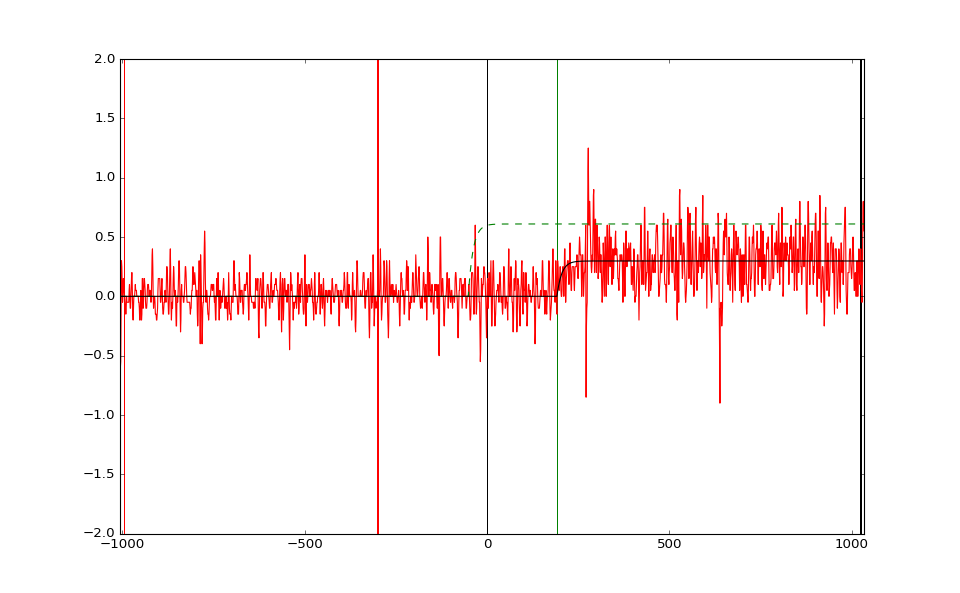

<Container object of 1 artists>

In [22]:
model = Model(vitesse)

params = Parameters()
params.add('tau', value=0.013, min=0.001, max=0.1, vary=False)
params.add('xT', value=0.05, min=0.001, max=0.1)#, vary=False)
params.add('t_T', value= 0.1, min=0.001, max=0.2, vary=False)
params.add('start', value=1000., min=0, max=2000.)#, vary=True)
params.add('bino', value=bino, min=0, max=1, vary=False)

result = model.fit(new_gradient_x, params, x=new_time)
print(result.fit_report())

latence = result.values['start']
print('latence = ', latence-debut)

new_latence = latence
for s in range(len(saccades)) :
    if new_latence > saccades[s][0]-trackertime_0 :
        new_latence = new_latence + saccades[s][2]
print('new_latence =', new_latence-debut)

fig, ax = plt.subplots(1, 1, figsize=(12, (12/1.6180)))


ax.axis([StimulusOn-10, TargetOff+10, -2, 2])
ax.plot(np.asarray(new_time)-debut, new_gradient_x, color='r')

ax.plot(np.asarray(new_time)-debut, result.init_fit, 'g--')
ax.plot(np.asarray(new_time)-debut, result.best_fit, 'k')

ax.bar(latence-debut, 4, bottom=-2, color='g', width=4, linewidth=0)


#ax.text(StimulusOn+15, -7, "%s"%(out.fit_report()), color='k', fontsize=6)


ax.bar(StimulusOn, 4, bottom=-2, color='r', width=4, linewidth=0)
ax.bar(StimulusOf, 4, bottom=-2, color='r', width=4, linewidth=0)

ax.bar(TargetOn, 4, bottom=-2, color='k', width=4, linewidth=0)
ax.bar(TargetOff, 4, bottom=-2, color='k', width=4, linewidth=0)